## Searching for Zinc Fingers and Domains in UniProt Annotations

This notebook reproduces Fig. S1, S2, and S5

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import urllib.parse
import urllib.request
import json
import pandas as pd
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.stats import binned_statistic, binned_statistic_2d


# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

folded_domains = ['C2H2', 'CCHHC', 'GATA', 'EGF-like', 'Fibronectin', 'Ig-like', 'PH',
'Cadherin', 'SH3', 'EF-hand', 'CCHC', 'LDL-receptor', 'SCAN box', 'VWFC',
'Laminin', 'Sushi', 'B30.2/SPRY', 'PID', 'C2', 'Myosin motor', 'Protein kinase'] 

def uniprot_api_features(segment):
    # Use the uniprot as input to fetch the protein name
    uniprot = segment.split('_')[0]
    start_index = int(segment.split('_')[1])
    end_index = int(segment.split('_')[2])
    url_template_uniprot = "https://rest.uniprot.org/uniprotkb/{}.json"
    url_uniprot = url_template_uniprot.format(uniprot)
    folded_counter = np.zeros(end_index-start_index+1)
    folded_counter_all = np.zeros(end_index-start_index+1)

    with urllib.request.urlopen(url_uniprot) as link:
        data_uniprot = json.loads(link.read().decode())
        try:
            features = data_uniprot['features']
        except:
            return np.empty(0),np.empty(0),np.empty(0),0,0
        if len(features) > 0:
            annotations = []
            descriptions = []
            other_descriptions = []
            for feature in features:
                if feature['type'] in ['Domain','Zinc finger']:
                    start_feature = feature['location']['start']['value']
                    end_feature = feature['location']['end']['value']
                    if start_feature == None:
                        length = 0
                    elif end_feature == None:
                        length = 0
                    else:
                        length = end_feature-start_feature
                    if length >= 10:
                        if (start_feature < start_index):
                            start_feature = start_index
                        if (end_feature > end_index):
                            end_feature = end_index
                        length = end_feature-start_feature
                        if length >= 10:
                            folded_counter_all[start_feature-start_index:end_feature-start_index] += 1
                            domain_in_sel = np.any([(fd in feature['description'] and 
                                                    'PHTF' not in feature['description']) 
                                                    for fd in folded_domains])
                            if domain_in_sel or feature['type'] == 'Zinc finger':
                                annotations.append(feature['type'])
                                descriptions.append(feature['description'])
                                if feature['type'] == 'Zinc finger':
                                    descriptions.append('Zinc finger')
                                folded_counter[start_feature-start_index:end_feature-start_index] += 1
                            else:
                                other_descriptions.append(feature['description'])
        return np.unique(annotations),np.unique(descriptions),np.unique(other_descriptions),np.sum(folded_counter!=0),np.sum(folded_counter_all!=0)

In [2]:
# Load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)[['nu','UniProt_ID','N']]

In [ ]:
for i,name in enumerate(df_idrome.index[:]):
    features, descriptions, other_descriptions, tot_length, tot_length_all = uniprot_api_features(name)
    if features.size>0:
        df_idrome.loc[name,'Features'] = ', '.join(features)
        df_idrome.loc[name,'N_Domain'] = tot_length_all
        df_idrome.loc[name,'Descriptions'] = ', '.join(descriptions)
        df_idrome.loc[name,'Other_Descriptions'] = ', '.join(other_descriptions)
    print(i,end='-')
    time.sleep(.5)

In [ ]:
df_idrome['N_Domain'] = df_idrome['N_Domain'].fillna(0) 
df_idrome['fdomain'] = df_idrome['N_Domain'] / df_idrome['N']
df_idrome.to_csv('IDRome_DB_Domains.csv')

In [65]:
# Load domain annotations
df_idrome = pd.read_csv('IDRome_DB_Domains.csv',index_col=0)

In [66]:
curated = df_idrome[~df_idrome.Descriptions.isnull()].Descriptions.apply(lambda x : x.split(','))

In [67]:
other = df_idrome[~df_idrome.Other_Descriptions.isnull()].Other_Descriptions.apply(lambda x : x.split(','))

#### Rename Domains with Shorthand Descriptions

In [68]:
def replace_w_substring(strings):
    strings = strings.split(', ')
    shorthand_description = ['C2', 'Zinc finger', 'EGF-like', 'Fibronectin', 'Ig-like', 'PH',
'Cadherin', 'SH3', 'EF-hand', 'LDL-receptor', 'SCAN box', 'VWFC',
'Laminin', 'Sushi', 'B30.2/SPRY', 'PID', 'Myosin motor', 'Protein kinase']
    for i,string in enumerate(strings):
        for substring in shorthand_description:
            if substring in string:
                strings[i] = substring
    if 'Zinc finger' in strings:
        strings = ['Zinc finger']
    return np.unique(strings)

def replace_w_substring_other(strings):
    strings = strings.split(', ')
    shorthand_description = ['Antistasin', 'FAS1', 'FZ', 'Follistatin', 'KRAB', 'Kazal', 
'MAM', 'NIDO', 'SEA', 'SRCR', 'TB' ,'TIL', 'TSP', 'BTB', 'Bromo', 'CTCK', 'CUB', 'Collagen', 
'DHHC', 'DSL', 'ELM2', 'EMI', 'F5/8', 'GPS', 'IQ', 'LRRCT', 
'PDZ', 'Ras-GEF', 'Rho-GAP', 'RhoBD', 'SAM', 'SET', 'SH2', 'SMP-LBD', 'VWFD', 'WH2']
    for i,string in enumerate(strings):
        for substring in shorthand_description:
            if substring in string:
                strings[i] = substring
    if 'Zinc finger' in strings:
        strings = ['Zinc finger']
    return np.unique(strings)

df_idrome['Short_Descriptions'] = df_idrome[~pd.isnull(df_idrome.Descriptions)].Descriptions.apply(
    lambda x : replace_w_substring(x))
df_idrome['Other_Short_Descriptions'] = df_idrome[~pd.isnull(df_idrome.Other_Descriptions)].Other_Descriptions.apply(
    lambda x : replace_w_substring_other(x))

#### Descriptions for IDRs with Multiple Domains of Different Type

In [69]:
df_idrome['Short_Descriptions'] = df_idrome[~pd.isnull(df_idrome.Descriptions)].Short_Descriptions.apply(
    lambda x : ' & '.join([str(s) for s in x]))
df_idrome['Other_Short_Descriptions'] = df_idrome[~pd.isnull(
    df_idrome.Other_Descriptions)].Other_Short_Descriptions.apply(
    lambda x : ' & '.join([str(s) for s in x]))

In [70]:
df_idrome['All_Short'] = df_idrome[['Short_Descriptions','Other_Short_Descriptions']].values.tolist()
df_idrome.query('fdomain > 0').All_Short

seq_name
A0A0J9YWL9_573_993       [Zinc finger, nan]
A0A0J9YY54_433_714       [Zinc finger, nan]
A0AVI2_121_328                    [C2, nan]
A0AVI2_1336_1400                  [C2, nan]
A0AVI2_952_1072                   [C2, nan]
                              ...          
Q9Y6K9_355_400           [Zinc finger, nan]
Q9Y6R6_785_833           [Zinc finger, nan]
Q9Y6S9_230_386        [Protein kinase, nan]
Q9Y6X6_951_1018         [Myosin motor, nan]
Q9Y6X8_1_89              [Zinc finger, nan]
Name: All_Short, Length: 1837, dtype: object

In [71]:
df_idrome['All_Short'] = df_idrome['All_Short'].apply(
    lambda x : [s for s in x if str(s) != 'nan'])

In [72]:
df_idrome['All_Short'] = df_idrome['All_Short'].apply(
    lambda x : ' & '.join([str(s) for s in x]) if type(x) == list else x)

#### Fig. S1

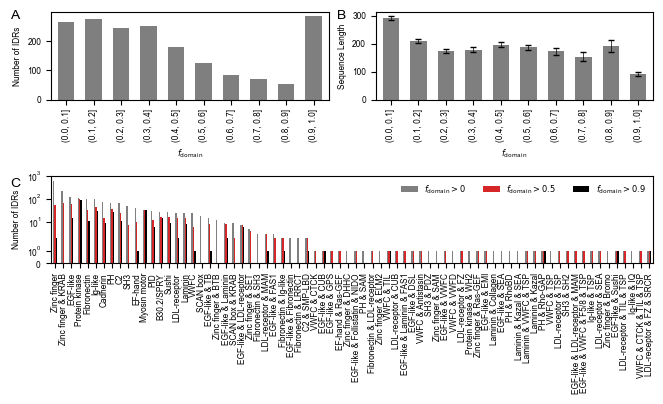

In [73]:
fig = plt.figure(figsize=(6.6,4))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

ax1 = plt.subplot2grid( (2,2), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (2,2), (0,1), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (2,2), (1,0), rowspan=1, colspan=2 )

intervals = pd.cut(df_idrome['fdomain'], np.arange(0, 1.05, .1))
df_idrome['fdomain'].groupby(intervals).agg(['count']).plot(rot=90, ax=ax1, kind='bar', 
                      color='tab:gray',width=.6,legend=False)

ax1.set_ylabel('Number of IDRs')

mean_se = df_idrome['N'].groupby(intervals).agg(['mean',se])
mean_se['mean'].plot(rot=90, ax=ax2, kind='bar', yerr=mean_se['SE'],color='tab:gray',
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),width=.6)

ax2.set_ylabel('Sequence Length')
ax1.set_xlabel(r'$f_{\mathrm{domain}}$')
ax2.set_xlabel(r'$f_{\mathrm{domain}}$')

counts = pd.DataFrame(columns=['$f_{\mathrm{domain}}>0$','$f_{\mathrm{domain}}>0.5$','$f_{\mathrm{domain}}>0.9$'])
counts['$f_{\mathrm{domain}}>0$'] = df_idrome.query('fdomain>0').All_Short.value_counts()
counts['$f_{\mathrm{domain}}>0.5$'] = df_idrome.query('fdomain>0.5').All_Short.value_counts()
counts['$f_{\mathrm{domain}}>0.9$'] = df_idrome.query('fdomain>0.9').All_Short.value_counts()
#counts = counts[counts>=20]
counts.index
counts.plot.bar(ax=ax3,color=['tab:gray','tab:red','k'])

ax3.set_ylabel('Number of IDRs')
ax3.set_yscale('symlog')
ax3.set_ylim(0,1000)

ax3.legend(frameon=False,ncol=3)

fig.text(0.01, .96, 'A', fontsize=10)
fig.text(0.01, .54, 'C', fontsize=10)
fig.text(0.506, .96, 'B', fontsize=10)

plt.tight_layout()

fig.savefig('figs/figS1.pdf',dpi=300)

#### Calculate Average pLDDT Scores

In [74]:
pLDDT = pd.read_csv('idr_selection/idr_pLDDT.csv.gz',header=0,sep=';')
pLDDT.sort_values('uniprot',inplace=True)
pLDDT['seq_name'] = pLDDT.uniprot+'_'+pLDDT['first'].apply(
    lambda x : '{:g}'.format(x))+'_'+pLDDT['last'].apply(lambda x : '{:g}'.format(x))
pLDDT['pLDDT_w20'] = pLDDT['pLDDT_w20'].apply(lambda x : 100*np.array(eval(x.replace(':',','))))
pLDDT['pLDDT_mean'] = pLDDT['pLDDT_w20'].apply(np.mean)
pLDDT.set_index('seq_name',inplace=True)
df_idrome['pLDDT'] = pLDDT['pLDDT_w20'].apply(np.mean)

#### Fig. S2

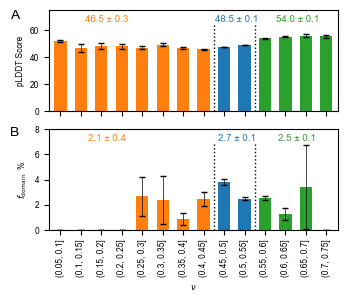

In [77]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(3.4,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

# bin nu values
intervals = pd.cut(df_idrome['nu'], np.arange(0.05, .76, .05))

ax1.set_xlim(3.5,13.5)

ax1.vlines([7.5,9.5],ymin=0,ymax=65,color='k',ls=':',lw=1)
ax1.set_ylim(0,75)

mean_se = df_idrome['pLDDT'].groupby(intervals).agg(['mean',se])
mean_se['mean'].plot(rot=90, ax=ax1, kind='bar', yerr=mean_se['SE'],
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      color=['tab:orange']*8+['tab:blue']*2+['tab:green']*4,width=.6)

intervals = pd.cut(df_idrome['nu'], np.array([0, .45, .55, .7]))
mean_se = df_idrome['pLDDT'].groupby(intervals).agg(['mean',se])

n_compact = mean_se.iloc[0]['mean']
n_theta = mean_se.iloc[1]['mean']
n_expanded = mean_se.iloc[-1]['mean']
n_compact_e = mean_se.iloc[0]['SE']
n_theta_e = mean_se.iloc[1]['SE']
n_expanded_e = mean_se.iloc[-1]['SE']

ax1.annotate(f'{n_compact:.1f} ± {n_compact_e:.1f}',xy=(.2,.88),
            xycoords='axes fraction',color='tab:orange',fontsize=7,ha='center')
ax1.annotate(f'{n_theta:.1f} ± {n_theta_e:.1f}',xy=(.65,.88),
            xycoords='axes fraction',color='tab:blue',fontsize=7,ha='center')
ax1.annotate(f'{n_expanded:.1f} ± {n_expanded_e:.1f}',xy=(.86,.88),
            xycoords='axes fraction',color='tab:green',fontsize=7,ha='center')

ax1.set_ylabel(r'pLDDT Score')

##################

# bin nu values
intervals = pd.cut(df_idrome['nu'], np.arange(0.05, .76, .05))

ax2.set_xlim(3.5,13.5)

ax2.vlines([7.5,9.5],ymin=0,ymax=7,color='k',ls=':',lw=1)
ax2.set_ylim(0,8)

mean_se = df_idrome['fdomain'].groupby(intervals).agg(['mean',se])*100
mean_se['mean'].plot(rot=90, ax=ax2, kind='bar', yerr=mean_se['SE'],
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      color=['tab:orange']*8+['tab:blue']*2+['tab:green']*4,width=.6)

intervals = pd.cut(df_idrome['nu'], np.array([0, .45, .55, .7]))
mean_se = df_idrome['fdomain'].groupby(intervals).agg(['mean',se])*100

n_compact = mean_se.iloc[0]['mean']
n_theta = mean_se.iloc[1]['mean']
n_expanded = mean_se.iloc[-1]['mean']
n_compact_e = mean_se.iloc[0]['SE']
n_theta_e = mean_se.iloc[1]['SE']
n_expanded_e = mean_se.iloc[-1]['SE']

ax2.annotate(f'{n_compact:.1f} ± {n_compact_e:.1f}',xy=(.2,.88),
            xycoords='axes fraction',color='tab:orange',fontsize=7,ha='center')
ax2.annotate(f'{n_theta:.1f} ± {n_theta_e:.1f}',xy=(.65,.88),
            xycoords='axes fraction',color='tab:blue',fontsize=7,ha='center')
ax2.annotate(f'{n_expanded:.1f} ± {n_expanded_e:.1f}',xy=(.86,.88),
            xycoords='axes fraction',color='tab:green',fontsize=7,ha='center')

ax2.set_ylabel(r'$f_{\mathrm{domain}}$  %')
ax2.set_xlabel(r'$\nu$')

fig.text(0.01, .94, 'A', fontsize=10)
fig.text(0.01, .55, 'B', fontsize=10)

plt.tight_layout()
fig.savefig('figs/figS2.pdf')

#### Fig. S5

In [60]:
qcdpred = pd.read_csv('QCDPred/idr_qcdpred2.csv.gz',header=0,sep=',',index_col='name')
qcdpred['QCDpred2'] = qcdpred['QCDpred2'].apply(lambda x : np.array(eval(x.replace(':',','))).astype(float))
df_idrome['QCDpred'] = qcdpred['QCDmean2'] 

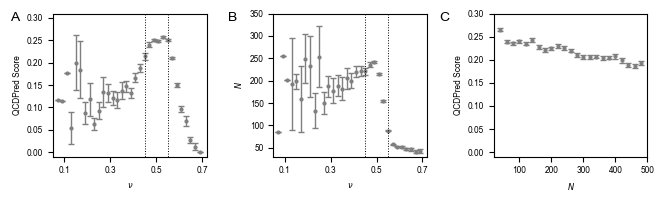

In [63]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(6.6,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bins = np.arange(0, .701, .02)
x = bins[:-1]+.01

average = binned_statistic(df_idrome.nu,df_idrome['QCDpred'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['QCDpred'],statistic=se,
                                     bins=bins)[0]

ax1.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color='tab:gray')

average = binned_statistic(df_idrome.nu,df_idrome['N'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['N'],statistic=se,
                                     bins=bins)[0]

ax2.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color='tab:gray')

bins = np.arange(30, 500, 20)
x = bins[:-1]+10

average = binned_statistic(df_idrome.N,df_idrome['QCDpred'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.N,df_idrome['QCDpred'],statistic=se,
                                     bins=bins)[0]

ax3.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color='tab:gray')

ax1.set_ylabel('QCDPred Score')
ax1.set_xlabel('$\\nu$')
ax1.vlines([.45,.55],ymin=-10,ymax=50,color='k',ls=':',lw=.7)
ax1.set_ylim(-.01,.31)

ax2.set_ylabel('$N$')
ax2.set_xlabel('$\\nu$')
ax2.vlines([.45,.55],ymin=-100,ymax=350,color='k',ls=':',lw=.7)
ax2.set_ylim(30,350)

ax3.set_xlim(20,500)
ax3.set_ylim(-.01,.3)
ax3.set_ylabel('QCDPred Score')
ax3.set_xlabel('$N$')

ax1.set_xlim(0.05,.72)
ax1.set_xticks([.1,.3,.5,.7])
ax2.set_xlim(0.05,.72)
ax2.set_xticks([.1,.3,.5,.7])

f.text(0.01, .9, 'A', fontsize=10)
f.text(0.34, .9, 'B', fontsize=10)
f.text(0.66, .9, 'C', fontsize=10)

plt.tight_layout(w_pad=3)

f.savefig('figs/figS5.pdf',dpi=300)

#### Save fraction of domains in main database

In [58]:
df_domains = pd.read_csv('IDRome_DB_Domains.csv',index_col=0)
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome['fdomain'] = df_domains['fdomain']
df_idrome.to_csv('IDRome_DB.csv')